In [1]:
from optim_relu_max_linear_v import OptimReluMaxLinearV
from check_grad_optim_v import test_optim_splade_model
import triton
import torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
torch.cuda.is_available()

True

In [3]:
B = 16
L = 100
D = 300
V = 100000
x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
b = -torch.sqrt(-2 * torch.log(torch.tensor(0.005, device='cuda').repeat(V))) * 21

res = x @ w + b.reshape(1, 1, *b.shape).max(axis=1)[0]
print((res > 0).sum() / (B * V))

tensor(0.0046, device='cuda:0')


In [4]:
UPPER_LIMIT = 11  ## change ca pour diminuer la consommation de memoire.
B = 16
L = 100
D = 200
x_vals = [10000 * i for i in range(1, UPPER_LIMIT)]

In [5]:
print(x_vals)

[10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]


In [6]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["V"],  # Argument names to use as an x-axis for the plot
        x_vals=x_vals,  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["torch", "triton"],  # Label name for the lines
        line_names= ["torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={'B' : B, 'L' : L, 'D': D},
    ))


In [7]:
@triton.testing.perf_report(configs)
def benchmark(V, B, L, D, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = -torch.sqrt(-2 * torch.log(torch.tensor(0.005, device='cuda').repeat(V))) * 21
    
    list_lengths = torch.randint(0, L, [B])
    
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
        
    quantiles = [0.5, 0.2, 0.8]
    
    print(f'---------- V : {V}\tprovider : {provider} ----------')
    
    if provider == 'torch':
        mask_inf = torch.where(mask == 1, 0, -torch.inf)
        
        relu = torch.nn.ReLU()  
        torch_calculation = relu(torch.max((x @ w) + b.reshape(1, 1, *b.shape) + mask_inf.reshape(*mask_inf.shape, 1), dim=1)[0])
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_calculation.sum().backward(retain_graph=True), quantiles=quantiles)
    if provider == 'triton':
        triton_calculation = OptimReluMaxLinearV.apply(x, w, b, mask)[0]
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_calculation.sum().backward(retain_graph=True) , quantiles=quantiles)
    gbps = lambda ms: 8 * (B * L * D + D * V + V) / (ms * 1e-3) / (1024 ** 3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

---------- V : 10000	provider : torch ----------
---------- V : 10000	provider : triton ----------
---------- V : 20000	provider : torch ----------
---------- V : 20000	provider : triton ----------
---------- V : 30000	provider : torch ----------
---------- V : 30000	provider : triton ----------
---------- V : 40000	provider : torch ----------
---------- V : 40000	provider : triton ----------
---------- V : 50000	provider : torch ----------
---------- V : 50000	provider : triton ----------
---------- V : 60000	provider : torch ----------
---------- V : 60000	provider : triton ----------
---------- V : 70000	provider : torch ----------
---------- V : 70000	provider : triton ----------
---------- V : 80000	provider : torch ----------
---------- V : 80000	provider : triton ----------
---------- V : 90000	provider : torch ----------
---------- V : 90000	provider : triton ----------
---------- V : 100000	provider : torch ----------
---------- V : 100000	provider : triton ----------


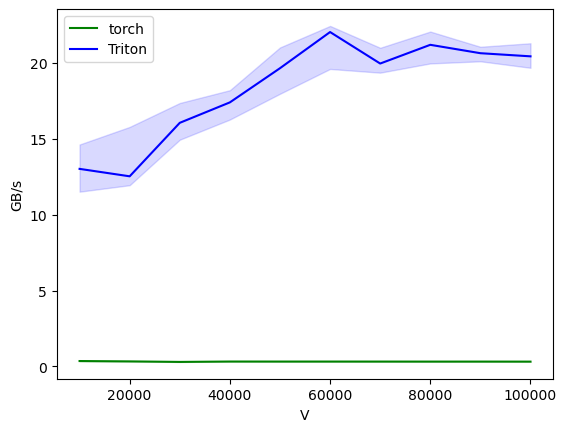

relu_max_backward_performance:
          V     torch     Triton
0   10000.0  0.357228  13.010730
1   20000.0  0.333597  12.521034
2   30000.0  0.298984  16.043085
3   40000.0  0.324278  17.389081
4   50000.0  0.322458  19.638647
5   60000.0  0.322684  22.020866
6   70000.0  0.321663  19.946852
7   80000.0  0.319969  21.179923
8   90000.0  0.320539  20.627486
9  100000.0  0.318189  20.421283


In [8]:
benchmark.run(show_plots=True, print_data=True)